<a href="https://colab.research.google.com/github/nmatsumoto-lgtm/study-KIKAGAKU/blob/main/%E4%B8%8D%E5%8B%95%E7%94%A3%E4%BE%A1%E6%A0%BC%E4%BA%88%E6%B8%AC%E3%82%A2%E3%83%97%E3%83%AA_Ver_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
!pip -q install lightgbm==4.5.0 optuna==3.6.1 joblib pandas numpy scikit-learn

In [93]:
from __future__ import annotations
import json
from pathlib import Path
from dataclasses import dataclass


import numpy as np
import pandas as pd
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_log_error
from joblib import dump

In [94]:
SEED = 0
np.random.seed(SEED)

In [95]:
IN = Path("data/interim/train_tabular.csv")
OUT_DIR = Path("models"); OUT_DIR.mkdir(parents=True, exist_ok=True)

In [96]:
# === 中央区 5エリア：駅→エリアの固定マップ ===
STATION_TO_AREA = {
    # ① 銀座・京橋
    "銀座": "銀座・京橋",
    "東銀座": "銀座・京橋",
    "銀座一丁目": "銀座・京橋",
    "京橋(東京)": "銀座・京橋",
    "宝町(東京)": "銀座・京橋",
    "新橋": "銀座・京橋",
    "汐留": "銀座・京橋",
    "東京": "銀座・京橋",  # 日本橋側に寄せたい場合は「日本橋・人形町」へ変更可

    # ② 日本橋・人形町
    "日本橋(東京)": "日本橋・人形町",
    "三越前": "日本橋・人形町",
    "新日本橋": "日本橋・人形町",
    "茅場町": "日本橋・人形町",
    "人形町": "日本橋・人形町",
    "水天宮前": "日本橋・人形町",
    "浜町": "日本橋・人形町",
    "東日本橋": "日本橋・人形町",
    "小伝馬町": "日本橋・人形町",
    "馬喰横山": "日本橋・人形町",
    "馬喰町": "日本橋・人形町",

    # ③ 月島・勝どき・晴海
    "月島": "月島・勝どき・晴海",
    "勝どき": "月島・勝どき・晴海",

    # ④ 築地・八丁堀
    "築地": "築地・八丁堀",
    "築地市場": "築地・八丁堀",
    "新富町(東京)": "築地・八丁堀",
    "八丁堀(東京)": "築地・八丁堀",
}

AREA_LIST = ["銀座・京橋", "日本橋・人形町", "月島・勝どき・晴海", "築地・八丁堀", "佃・新川・湊", "その他"]

def station_to_area(station_name: str) -> str:
    """駅名を5エリアに変換。未登録は 'その他'。"""
    if not isinstance(station_name, str) or station_name.strip() == "":
        return "その他"
    return STATION_TO_AREA.get(station_name.strip(), "その他")

In [97]:
# ============================
# 1) データ読み込み & 追加特徴量
# ============================

def _oof_target_median(df: pd.DataFrame, key: str, y: np.ndarray, n_splits: int = 5) -> np.ndarray:
    """キー列ごとの OOF 中央値エンコーディング（リーク防止）。
    戻り値は各行に対応する OOF 推定値（学習折ごとに学習外の中央値を使う）。
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof = np.zeros(len(df), dtype=float)
    for tr_idx, va_idx in kf.split(df):
        med = (
            pd.DataFrame({key: df.iloc[tr_idx][key].values, "y": y[tr_idx]})
            .groupby(key)["y"].median()
        )
        oof[va_idx] = df.iloc[va_idx][key].map(med).fillna(med.median()).values
    return oof

def _oof_target_mean(df, key, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof = np.zeros(len(df), dtype=float)
    for tr_idx, va_idx in kf.split(df):
        m = (pd.DataFrame({key: df.iloc[tr_idx][key].values, "y": y[tr_idx]})
             .groupby(key)["y"].mean())
        oof[va_idx] = df.iloc[va_idx][key].map(m).fillna(m.mean()).values
    return oof

def build_table_and_features() -> tuple[pd.DataFrame, list[str], list[str], list[str], list[int]]:
    df = pd.read_csv(IN)

    # ===== 対数ターゲット =====
    y = df["price_yen"].astype(float).values
    y_log = np.log1p(y)

    # ===== 5エリアを駅から自動付与（入力は駅のまま）=====
    df["area_group"] = df["station"].astype(str).apply(station_to_area)

    # ===== 追加特徴量 =====
    df["access_score"] = 1.0 / (1.0 + df["walk_min"].astype(float))
    df["sqrt_area"]    = np.sqrt(np.clip(df["area_sqm"].astype(float), 0, None))
    df["log_area"]     = np.log1p(np.clip(df["area_sqm"].astype(float), 0, None))
    df["age_sqrt"]     = np.sqrt(np.clip(df["築年数"].astype(float), 0, None))
    df["area_x_access"]= df["area_sqm"].astype(float) * df["access_score"].astype(float)

    # ===== 頻度特徴量 =====
    station_cnt = df["station"].value_counts()
    layout_cnt  = df["layout"].value_counts()
    area_cnt    = df["area_group"].value_counts()

    df["station_count"] = df["station"].map(station_cnt).fillna(0).astype(int)
    df["layout_count"]  = df["layout"].map(layout_cnt).fillna(0).astype(int)
    df["area_count"]    = df["area_group"].map(area_cnt).fillna(0).astype(int)

    # ===== OOF 目標エンコード（対数ターゲットで中央値）=====
    df["station_oof_median_log"] = _oof_target_median(df, "station",     y_log)
    df["layout_oof_median_log"]  = _oof_target_median(df, "layout",      y_log)
    df["area_oof_median_log"]    = _oof_target_median(df, "area_group",  y_log)

    # ===== OOF 目標エンコード（対数ターゲットで平均）=====  ←★ ここを追加
    df["station_oof_mean_log"] = _oof_target_mean(df, "station",    y_log)
    df["layout_oof_mean_log"]  = _oof_target_mean(df, "layout",     y_log)
    df["area_oof_mean_log"]    = _oof_target_mean(df, "area_group", y_log)


    # ===== 推論用に学習時統計を準備 =====
    station_med_map = (
        pd.DataFrame({"station": df["station"], "y_log": y_log})
        .groupby("station")["y_log"].median().to_dict()
    )
    layout_med_map = (
        pd.DataFrame({"layout": df["layout"], "y_log": y_log})
        .groupby("layout")["y_log"].median().to_dict()
    )
    area_med_map = (
        pd.DataFrame({"area_group": df["area_group"], "y_log": y_log})
        .groupby("area_group")["y_log"].median().to_dict()
    )

    # ←★ ここから “平均” を追加
    station_mean_map = (
        pd.DataFrame({"station": df["station"], "y_log": y_log})
        .groupby("station")["y_log"].mean().to_dict()
    )
    layout_mean_map = (
        pd.DataFrame({"layout": df["layout"], "y_log": y_log})
        .groupby("layout")["y_log"].mean().to_dict()
    )
    area_mean_map = (
        pd.DataFrame({"area_group": df["area_group"], "y_log": y_log})
        .groupby("area_group")["y_log"].mean().to_dict()
    )

    global_station_med = float(np.median(list(station_med_map.values()))) if len(station_med_map) else float(np.median(y_log))
    global_layout_med  = float(np.median(list(layout_med_map.values())))  if len(layout_med_map)  else float(np.median(y_log))
    global_area_med    = float(np.median(list(area_med_map.values())))    if len(area_med_map)    else float(np.median(y_log))

    # 参考：平均の“全体値”も欲しければ
    global_station_mean = float(np.mean(list(station_mean_map.values()))) if len(station_mean_map) else float(np.mean(y_log))
    global_layout_mean  = float(np.mean(list(layout_mean_map.values())))  if len(layout_mean_map)  else float(np.mean(y_log))
    global_area_mean    = float(np.mean(list(area_mean_map.values())))    if len(area_mean_map)    else float(np.mean(y_log))

    # ===== カテゴリ列（area を先頭に追加）=====
    feat_cat = ["area_group", "station", "layout"]

    # ===== 数値列 =====
    feat_num_base = ["walk_min", "築年数", "area_sqm"]
    feat_num_extra = [
        "access_score", "sqrt_area", "log_area", "age_sqrt",
        "area_x_access",
        "station_count", "layout_count", "area_count",
        "station_oof_median_log", "layout_oof_median_log", "area_oof_median_log",
        "station_oof_mean_log", "layout_oof_mean_log", "area_oof_mean_log",
    ]
    feat_num_all = feat_num_base + feat_num_extra

    # 単調制約を「名前で」安全に指定
    mono_dict = {name: 0 for name in feat_num_all}
    mono_dict.update({
        "walk_min": -1,      # 遠いほど↓
        "築年数": -1,         # 古いほど↓
        "area_sqm": +1,      # 広いほど↑
        # ← 派生も一貫させる
        "access_score": +1,  # 駅近スコアが高いほど↑（walk_minと反対符号に注意だが整合的）
        "sqrt_area": +1,
        "log_area": +1,
        "age_sqrt": -1,
     })
    monotone_constraints = [0] * len(feat_cat) + [mono_dict[c] for c in feat_num_all]

    # # ===== 単調性制約（[cat..., num...] の順）=====
    # n_cat = len(feat_cat)
    # # walk_min↓, 築年数↓, area_sqm↑、その他は制約なし
    # mono_num = [-1, -1, +1] + [0] * (len(feat_num_all) - 3)
    # monotone_constraints = [0] * n_cat + mono_num

    # ===== ここから：新しいほど重くする sample_weight =====
    # 年月を「通算月」に変換（最新月との差＝どれだけ古いか）
    year_s  = pd.to_numeric(df["year"],  errors="coerce").astype(int)
    month_s = pd.to_numeric(df["month"], errors="coerce").astype(int)

    latest_m = int(year_s.max())*12 + int(month_s.max())          # スカラ
    this_m   = (year_s*12 + month_s)                               # Series（ベクトル計算）
    months_old = (latest_m - this_m).clip(lower=0)

    HALF_LIFE_MONTHS = 12.0  # 半減期（例：12ヶ月）。強めに効かせたいなら 6 にする等
    w = np.power(0.5, months_old / HALF_LIFE_MONTHS)
    w = np.clip(w, 0.2, None)  # 古すぎるデータにも最低限の重み（お好みで調整）
    sample_weight = w.values.astype(float)
    # ===== ここまで =====

    # ===== エンコードして学習用テーブル =====
    oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_cat = oe.fit_transform(df[feat_cat].fillna("NA")).astype("int32")
    X_num = df[feat_num_all].astype(float).values
    X = np.hstack([X_cat, X_num])

    cat_cols = [f"cat__{c}" for c in feat_cat]
    num_cols = feat_num_all.copy()
    X_df = pd.DataFrame(X, columns=cat_cols + num_cols)
    categorical_feature = cat_cols

    meta = {
        "feat_cat": feat_cat,
        "feat_num": num_cols,
        "categorical_feature": categorical_feature,
        "monotone_constraints": monotone_constraints,
    }

    # ===== 推論用マップ（station→area を含めて保存）=====
    infer_maps = {
        "station_count_map": station_cnt.to_dict(),
        "layout_count_map":  layout_cnt.to_dict(),
        "area_count_map":    area_cnt.to_dict(),

        "station_median_log_map": station_med_map,
        "layout_median_log_map":  layout_med_map,
        "area_median_log_map":    area_med_map,

        "global_station_median_log": global_station_med,
        "global_layout_median_log":  global_layout_med,
        "global_area_median_log":    global_area_med,

        # ↓↓↓ 追加（平均）
        "station_mean_log_map": station_mean_map,
        "layout_mean_log_map":  layout_mean_map,
        "area_mean_log_map":    area_mean_map,

        "global_station_median_log": global_station_med,
        "global_layout_median_log":  global_layout_med,
        "global_area_median_log":    global_area_med,

        # （必要なら平均の全体値も）
        "global_station_mean_log": global_station_mean,
        "global_layout_mean_log":  global_layout_mean,
        "global_area_mean_log":    global_area_mean,

        "station_to_area_map": {s: station_to_area(s) for s in sorted(df["station"].astype(str).unique())},
        "area_groups": AREA_LIST,

        "feat_cat": feat_cat,
        "feat_num": num_cols,

        # 駅→エリア（推論で駅入力から自動付与）
        "station_to_area_map": {s: station_to_area(s) for s in sorted(df["station"].astype(str).unique())},
        "area_groups": AREA_LIST,

        "feat_cat": feat_cat,
        "feat_num": num_cols,
    }

    # 返り値（従来どおり）
    return X_df, y_log, categorical_feature, monotone_constraints, meta, oe, infer_maps, sample_weight

In [98]:
# ============================
# 2) Optuna でハイパラ探索
# ============================

def tune_with_optuna(
    X_df: pd.DataFrame,
    y_log: np.ndarray,
    categorical_feature: list[str],
    monotone_constraints: list[int],
    n_trials: int = 80,
    sample_weight: np.ndarray | None = None  # ★ 追加
) -> tuple[dict, int, float]:
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

    def objective(trial: optuna.Trial) -> float:
        params = {
            "objective": "rmse",  # 対数価格の RMSE → RMSLE 等価
            "metric": "rmse",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 255),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 5.0),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "verbosity": -1,
            "seed": SEED,
            "monotone_constraints": monotone_constraints,
        }
        rmsles = []
        best_iters = []
        for tr_idx, va_idx in kf.split(X_df):
            X_tr, X_va = X_df.iloc[tr_idx], X_df.iloc[va_idx]
            y_tr, y_va = y_log[tr_idx], y_log[va_idx]
            w_tr = None if sample_weight is None else sample_weight[tr_idx]  # ★
            w_va = None if sample_weight is None else sample_weight[va_idx]  # ★

            dtr = lgb.Dataset(X_tr, label=y_tr, weight=w_tr,  # ★ weight を渡す
                              categorical_feature=categorical_feature, free_raw_data=True)
            dva = lgb.Dataset(X_va, label=y_va, weight=w_va,  # ★
                              categorical_feature=categorical_feature, free_raw_data=True)

            model = lgb.train(
                params,
                dtr,
                valid_sets=[dva],
                num_boost_round=4000,
                callbacks=[lgb.early_stopping(200, verbose=False)],
            )
            pred_log = model.predict(X_va, num_iteration=model.best_iteration)
            # y_log の RMSE = RMSLE（expm1 に戻した価格に対する）
            rmsle = float(np.sqrt(mean_squared_log_error(np.expm1(y_va), np.expm1(pred_log))))
            rmsles.append(rmsle)
            best_iters.append(model.best_iteration)
        trial.set_user_attr("best_iters", best_iters)
        return float(np.mean(rmsles))

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    # CV で選ばれた best_iteration を平均化
    best_iters_list = study.best_trial.user_attrs.get("best_iters", [1000])
    best_round = int(np.clip(np.mean(best_iters_list), 100, 4000))
    best_score = study.best_value
    return best_params, best_round, best_score

In [99]:
# ============================
# 3) 最終学習（ポイント & 分位点）
# ============================

def train_final_models(
    X_df: pd.DataFrame,
    y_log: np.ndarray,
    categorical_feature: list[str],
    monotone_constraints: list[int],
    best_params: dict,
    best_round: int,
    sample_weight: np.ndarray | None = None  # ★ 追加
):
    base_params = dict(best_params)
    base_params.update({
        "objective": "rmse",
        "metric": "rmse",
        "verbosity": -1,
        "seed": SEED,
        # ★ ポイントモデルでは単調性制約を使う
        "monotone_constraints": monotone_constraints,
    })

    # 生データを解放しない（categorical_feature を後で使えるように）
    dtrain = lgb.Dataset(
        X_df,
        label=y_log,
        weight=sample_weight,
        categorical_feature=categorical_feature,
        free_raw_data=False
    )

    # ---- ポイント（対数価格）----
    model_point = lgb.train(base_params, dtrain, num_boost_round=best_round)

    # ---- smearing（log1p → 円の戻し補正）----
    pred_log_tr = model_point.predict(X_df, num_iteration=getattr(model_point, "best_iteration", None))
    resid = y_log - pred_log_tr  # eps = y_log - yhat_log
    # ★ 直近重視の設計と整合：重み付き平均（重みが無いときは従来どおり）
    smearing = (
        float(np.average(np.exp(resid), weights=sample_weight))
        if sample_weight is not None else
        float(np.mean(np.exp(resid)))
    )

    # ---- 分位点（q10/q90）----
    models_q = {}
    for alpha, tag in [(0.1, "q10"), (0.9, "q90")]:
        q_params = dict(best_params)
        q_params.update({
            "objective": "quantile",
            "alpha": alpha,
            "metric": "quantile",
            "verbosity": -1,
            "seed": SEED,
            # ★ ここが重要：quantile では単調性制約を外す
            # "monotone_constraints": monotone_constraints,  # ←入れない
        })
        models_q[tag] = lgb.train(q_params, dtrain, num_boost_round=best_round)

    return model_point, models_q, smearing


In [100]:
# ===== 入力CSV→中間CSVの自動生成（なければ作る） =====
from pathlib import Path
import pandas as pd, numpy as np, re
from datetime import datetime

RAW_CSV = Path("/content/Tokyo_Chuo Ward_20242_20251.csv")
IN = Path("data/interim/train_tabular.csv")
ST_OUT = Path("data/interim/stations.csv")
IN.parent.mkdir(parents=True, exist_ok=True)

# ===== _read_chuo_and_save() の先頭付近に追加（関数の外でOK）=====
def _parse_period(s):
    """'2025年8月', '2025/08', '2025-8', '2025年第2四半期' などを (year, month) に直す"""
    import re, math
    if pd.isna(s): return (np.nan, np.nan)
    s = str(s)

    # 年月パターン
    m = re.search(r"(\d{4})[年/\-\. ]+(\d{1,2})", s)
    if m:
        y, mo = int(m.group(1)), int(m.group(2))
        mo = int(np.clip(mo, 1, 12))
        return (y, mo)

    # 四半期パターン
    m = re.search(r"(\d{4})年?第?([1-4])四半期", s)
    if m:
        y, q = int(m.group(1)), int(m.group(2))
        q2m = {1:1, 2:4, 3:7, 4:10}
        return (y, q2m[q])

    # 年だけ
    m = re.search(r"(\d{4})年", s)
    if m:
        return (int(m.group(1)), 1)

    return (np.nan, np.nan)

def _read_chuo_and_save(raw_csv: Path, out_csv: Path, stations_csv: Path):
    # エンコーディングを順に試す（Excel想定）
    last_err = None
    for enc in ("cp932", "utf-8-sig", "utf-8", "utf-16", "utf-16le", "utf-16be"):
        try:
            raw = pd.read_csv(raw_csv, encoding=enc)
            break
        except Exception as e:
            last_err = e
            raw = None
    if raw is None:
        raise last_err

    def _to_year(x):
        if pd.isna(x):
            return np.nan
        m = re.search(r"(\d{4})年", str(x))
        return int(m.group(1)) if m else np.nan

    # 必要列だけ取り出し
    df = raw[["最寄駅：名称","最寄駅：距離（分）","間取り","面積（㎡）","建築年","取引価格（総額）"]].copy()

    build_year = df["建築年"].apply(_to_year)
    current_year = datetime.now().year
    df["築年数"] = (current_year - build_year).clip(lower=0)

    for col in ["最寄駅：距離（分）","面積（㎡）","築年数"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(df[col].median())

    def _normalize_layout(s):
        if not isinstance(s, str):
            return "その他"
        s = (s.upper()
               .replace("Ｌ","L").replace("Ｄ","D").replace("Ｋ","K").replace("Ｒ","R"))
        m = re.search(r"(\d+)(LDK|DK|K|R)", s)
        return m.group(0) if m else "その他"

    # ★ ここは _normalize_layout の「外」（= 同じインデント階層）
    period_col = None
    for c in ["取引時期", "取引時点", "成約年月", "契約年月", "年月", "取引年月"]:
        if c in raw.columns:
            period_col = c
            break

    if period_col is not None:
        ym = raw[period_col].apply(_parse_period)
        year  = ym.apply(lambda t: t[0]).astype("Int64")
        month = ym.apply(lambda t: t[1]).astype("Int64")
    else:
        year  = pd.Series([np.nan] * len(raw), dtype="Int64")
        month = pd.Series([np.nan] * len(raw), dtype="Int64")

    # 欠損処理
    if year.isna().all():
        now = datetime.now()
        year  = pd.Series([now.year]  * len(raw))
        month = pd.Series([now.month] * len(raw))
    else:
        year  = year.fillna(method="ffill").fillna(method="bfill").astype(int)
        month = month.fillna(method="ffill").fillna(method="bfill").astype(int)

    # 学習用テーブル作成
    train = df.rename(columns={
        "最寄駅：名称": "station",
        "最寄駅：距離（分）": "walk_min",
        "面積（㎡）": "area_sqm",
        "取引価格（総額）": "price_yen",
    })[["station","walk_min","築年数","area_sqm","price_yen"]].copy()

    train["layout"] = df["間取り"].astype(str).apply(_normalize_layout)
    train["year"]   = year.astype(int)
    train["month"]  = month.astype(int)
    train["period"] = train["year"] * 100 + train["month"]

    # 保存
    train.to_csv(out_csv, index=False)

    # 駅リスト保存（utf-8-sig）
    s = (raw["最寄駅：名称"].astype(str)
           .replace({"nan": np.nan, "None": np.nan, "": np.nan})
           .dropna()
           .str.normalize("NFKC")
           .str.replace("（","(",regex=False).str.replace("）",")",regex=False)
           .str.replace("　"," ",regex=False).str.strip()
           .str.replace(r"\s+"," ",regex=True))
    pd.Series(sorted(s.unique())).to_csv(stations_csv, index=False, header=False, encoding="utf-8-sig")

# まだ中間CSVがない場合は作る
# if not IN.exists():
#     if not RAW_CSV.exists():
#         raise FileNotFoundError(f"Raw CSV が見つかりません: {RAW_CSV.resolve()}")
#     _read_chuo_and_save(RAW_CSV, IN, ST_OUT)
# ★ 一度だけ True にしてCSVを作り直す（year/month/period列を付与）
FORCE_REBUILD = True   # 生成が終わったら False に戻す/この行を消す

if FORCE_REBUILD or not IN.exists():
   if not RAW_CSV.exists():
      raise FileNotFoundError(f"Raw CSV が見つかりません: {RAW_CSV.resolve()}")
   _read_chuo_and_save(RAW_CSV, IN, ST_OUT)

/tmp/ipython-input-3543178640.py:97: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  year  = year.fillna(method="ffill").fillna(method="bfill").astype(int)
/tmp/ipython-input-3543178640.py:98: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  month = month.fillna(method="ffill").fillna(method="bfill").astype(int)


In [101]:
tmp = pd.read_csv(IN)
print(tmp.columns.tolist())
# 'year', 'month', 'period' が含まれていること
print(tmp.head())

['station', 'walk_min', '築年数', 'area_sqm', 'price_yen', 'layout', 'year', 'month', 'period']
   station  walk_min   築年数  area_sqm  price_yen layout  year  month  period
0  新富町(東京)       3.0  24.0        75  140000000   ３LDK  2024      4  202404
1  新富町(東京)       3.0  46.0        40   26000000     ２K  2024      4  202404
2  新富町(東京)       3.0  18.0        45   56000000   １LDK  2024      4  202404
3  新富町(東京)       1.0  27.0        35   47000000   １LDK  2024      4  202404
4  新富町(東京)       3.0  18.0        45   58000000   １LDK  2024      4  202404


In [102]:
# ============================
# 4) 実行
# ============================

if __name__ == "__main__":
    assert IN.exists(), f"Not found: {IN}"

    # ★ infer_maps まで受け取る（関数が infer_maps を返す実装になっている前提）
    X_df, y_log, cat_cols, mono_cons, meta, oe, infer_maps, sample_weight = build_table_and_features()

    print(f"Train rows: {len(X_df):,}, cols: {X_df.shape[1]} (cats={len(cat_cols)})")

    best_params, best_round, best_score = tune_with_optuna(
        X_df, y_log, cat_cols, mono_cons, n_trials=80, sample_weight=sample_weight
    )
    print("[OPTUNA] best RMSLE:", round(best_score, 4))
    print("[OPTUNA] best params:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    print("[OPTUNA] best_round:", best_round)

    model_point, models_q, smearing = train_final_models(
        X_df, y_log, cat_cols, mono_cons, best_params, best_round,
    sample_weight=sample_weight
    )

    # ===== 保存 =====
    # 予測時に使うメタ情報（列順や制約）とエンコーダを一緒に保存しておく
    dump({
        "model": model_point,
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen",
        "smearing": smearing,
    }, OUT_DIR / "lgbm_optuna_point.pkl")

    dump({
        "model": models_q["q10"],
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen",
        "alpha": 0.1,
        "smearing": smearing,
    }, OUT_DIR / "lgbm_optuna_q10.pkl")

    dump({
        "model": models_q["q90"],
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen",
        "alpha": 0.9,
        "smearing": smearing,
    }, OUT_DIR / "lgbm_optuna_q90.pkl")

    with open(OUT_DIR / "feature_config.json", "w", encoding="utf-8") as f:
        json.dump({
            "feat_cat": meta["feat_cat"],
            "feat_num": meta["feat_num"],
            "categorical_feature": meta["categorical_feature"],
            "monotone_constraints": meta["monotone_constraints"],
            "notes": "y is log1p(price_yen). During inference, apply expm1 to predictions.",
        }, f, ensure_ascii=False, indent=2)

    # ★ 推論用マップも保存（カッコを閉じるのを忘れない）
    with open(OUT_DIR / "infer_maps.json", "w", encoding="utf-8") as f:
        json.dump(infer_maps, f, ensure_ascii=False, indent=2)

    print("Saved models →", OUT_DIR)


[I 2025-09-06 06:29:59,489] A new study created in memory with name: no-name-322e90e1-eea2-432b-a827-38bbcc907595


Train rows: 1,784, cols: 20 (cats=3)


[I 2025-09-06 06:30:00,241] Trial 0 finished with value: 0.26658074192901265 and parameters: {'learning_rate': 0.02611213998390181, 'num_leaves': 133, 'min_data_in_leaf': 95, 'feature_fraction': 0.7919927835037436, 'bagging_fraction': 0.7961997258757834, 'bagging_freq': 4, 'min_gain_to_split': 4.328047163730711, 'lambda_l1': 0.029273954287438043, 'lambda_l2': 2.854673113858705}. Best is trial 0 with value: 0.26658074192901265.
[I 2025-09-06 06:30:06,496] Trial 1 finished with value: 0.2534442845808057 and parameters: {'learning_rate': 0.03773559635952192, 'num_leaves': 165, 'min_data_in_leaf': 132, 'feature_fraction': 0.6753150854729322, 'bagging_fraction': 0.734408781134311, 'bagging_freq': 6, 'min_gain_to_split': 2.6168487579145676, 'lambda_l1': 1.8037830722977403e-06, 'lambda_l2': 0.054802383643811875}. Best is trial 1 with value: 0.2534442845808057.
[I 2025-09-06 06:30:09,635] Trial 2 finished with value: 0.2312588330354183 and parameters: {'learning_rate': 0.07285440916116868, 'nu

[OPTUNA] best RMSLE: 0.18
[OPTUNA] best params:
  learning_rate: 0.030790882259330302
  num_leaves: 101
  min_data_in_leaf: 15
  feature_fraction: 0.7076837477983039
  bagging_fraction: 0.9697476958438329
  bagging_freq: 8
  min_gain_to_split: 0.025059052262594233
  lambda_l1: 1.0476822281035232e-05
  lambda_l2: 0.001046747765120844
[OPTUNA] best_round: 194
Saved models → models


                   feature   importance
5                 area_sqm  3445.995878
7                sqrt_area  1408.117594
4                      築年数   586.038556
15   layout_oof_median_log   356.010626
9                 age_sqrt   192.274147
10           area_x_access   125.285754
8                 log_area   103.355030
18     layout_oof_mean_log    56.226655
11           station_count    30.916647
14  station_oof_median_log    26.950376
3                 walk_min    26.224520
12            layout_count    26.013520
2              cat__layout    24.338794
17    station_oof_mean_log    22.652592
1             cat__station    19.110031
16     area_oof_median_log    12.634894
6             access_score    10.809611
19       area_oof_mean_log     7.287944
13              area_count     3.591242
0          cat__area_group     2.229897


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31689 (\N{CJK UNIFIED IDEOGRAPH-7BC9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


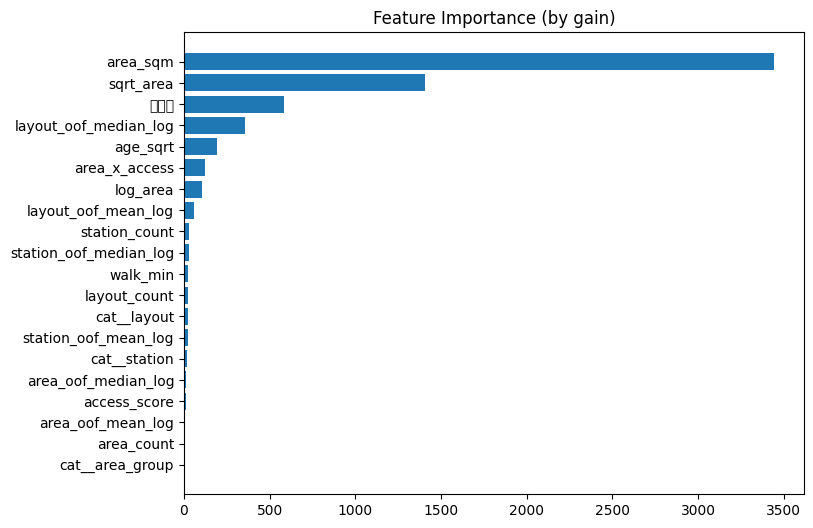

In [103]:
import matplotlib.pyplot as plt

# 重要度を取得
importance = model_point.feature_importance(importance_type="gain")
feature_names = model_point.feature_name()

# DataFrame化
import pandas as pd
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
}).sort_values("importance", ascending=False)

print(fi)

# 棒グラフで可視化
plt.figure(figsize=(8, 6))
plt.barh(fi["feature"], fi["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (by gain)")
plt.show()

In [104]:
# ===== ここから追加：学習＆検証（OOF）精度の表示 =====
from sklearn.metrics import r2_score
import numpy as np

def _fmt_metric_row(tag, rmsle, r2, rmse_y, mae_y, mape):
    print(f"[{tag}] RMSLE={rmsle:.4f} | R2(log)={r2:.4f} | RMSE(円)={rmse_y:,.0f} | MAE(円)={mae_y:,.0f} | MAPE={mape:.2f}%")

def _yen_metrics(y_true_yen: np.ndarray, y_pred_yen: np.ndarray):
    rmse_y = float(np.sqrt(np.mean((y_true_yen - y_pred_yen) ** 2)))
    mae_y  = float(np.mean(np.abs(y_true_yen - y_pred_yen)))
    mape   = float(np.mean(np.abs((y_true_yen - y_pred_yen) / np.clip(y_true_yen, 1.0, None))) * 100.0)
    return rmse_y, mae_y, mape

# ① 学習データ上の精度（= 学習済み model_point をそのまま評価）
best_it = getattr(model_point, "best_iteration", None)
y_log_pred_tr = model_point.predict(X_df, num_iteration=best_it)

# log空間のRMSEは価格空間のRMSLEに等価
rmsle_tr = float(np.sqrt(np.mean((y_log - y_log_pred_tr) ** 2)))
r2_tr    = float(r2_score(y_log, y_log_pred_tr))

# 円スケール（smearing補正を適用）の誤差
y_true_yen = np.expm1(y_log)
# smearing が無い場合は 1.0 にフォールバック
try:
    smear = float(smearing)
except NameError:
    smear = 1.0
y_pred_yen_tr = smear * np.expm1(y_log_pred_tr)
rmse_y_tr, mae_y_tr, mape_tr = _yen_metrics(y_true_yen, y_pred_yen_tr)

_fmt_metric_row("TRAIN", rmsle_tr, r2_tr, rmse_y_tr, mae_y_tr, mape_tr)

# ② KFold OOF（疑似バリデーション）での精度
from sklearn.model_selection import KFold
import lightgbm as lgb

kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
oof_pred_log = np.zeros_like(y_log, dtype=float)

# best_params / best_round / cat_cols / mono_cons は既存の変数を使用
for tr_idx, va_idx in kf.split(X_df):
    X_tr, X_va = X_df.iloc[tr_idx], X_df.iloc[va_idx]
    y_tr, y_va = y_log[tr_idx], y_log[va_idx]

     # ★ 追加：重みをfoldごとにスライス
    w_tr = None if 'sample_weight' not in globals() or sample_weight is None else sample_weight[tr_idx]
    w_va = None if 'sample_weight' not in globals() or sample_weight is None else sample_weight[va_idx]

    # ★ ここで weight=... を渡す
    dtr = lgb.Dataset(
        X_tr, label=y_tr, weight=w_tr,
        categorical_feature=cat_cols, free_raw_data=True
    )
    dva = lgb.Dataset(
        X_va, label=y_va, weight=w_va,
        categorical_feature=cat_cols, free_raw_data=True
    )

    params = dict(best_params)
    params.update({
        "objective": "rmse",
        "metric": "rmse",
        "verbosity": -1,
        "seed": SEED,
        "monotone_constraints": mono_cons,
    })

    booster = lgb.train(
        params, dtr,
        num_boost_round=best_round,
        valid_sets=[dva],
        callbacks=[],  # ここでは早停なし（best_round固定）
    )
    oof_pred_log[va_idx] = booster.predict(X_va, num_iteration=getattr(booster, "best_iteration", None))

# OOFのRMSLE（= log空間RMSE）
rmsle_oof = float(np.sqrt(np.mean((y_log - oof_pred_log) ** 2)))
r2_oof    = float(r2_score(y_log, oof_pred_log))

# 円スケールでの誤差（※OOFはsmearingをかけないのが一般的／参考用にそのまま）
y_pred_oof_yen = np.expm1(oof_pred_log)
rmse_y_oof, mae_y_oof, mape_oof = _yen_metrics(y_true_yen, y_pred_oof_yen)

_fmt_metric_row("OOF", rmsle_oof, r2_oof, rmse_y_oof, mae_y_oof, mape_oof)
# ===== ここまで追加 =====

def _weighted_mean(x, w):
    w = np.asarray(w, dtype=float)
    return float(np.sum(w * x) / np.sum(w))

def _yen_metrics_weighted(y_true_yen, y_pred_yen, w):
    w = np.asarray(w, dtype=float)
    rmse_y = float(np.sqrt(_weighted_mean((y_true_yen - y_pred_yen)**2, w)))
    mae_y  = float(_weighted_mean(np.abs(y_true_yen - y_pred_yen), w))
    mape   = float(_weighted_mean(np.abs((y_true_yen - y_pred_yen) / np.clip(y_true_yen, 1.0, None)), w) * 100.0)
    return rmse_y, mae_y, mape

# --- ★ 追加：重み付き OOF（“直近重視”の成績を見る） ---
if 'sample_weight' in globals() and sample_weight is not None:
    # log空間の重み付き RMSE = 価格空間の重み付き RMSLE に相当
    rmsle_oof_w = float(np.sqrt(_weighted_mean((y_log - oof_pred_log)**2, sample_weight)))
    # R2 は重み付きでの定義が複数ありますが、ここでは参考として未表示でもOK（必要なら実装可）
    rmse_y_oof_w, mae_y_oof_w, mape_oof_w = _yen_metrics_weighted(y_true_yen, y_pred_oof_yen, sample_weight)
    _fmt_metric_row("OOF[w]", rmsle_oof_w, r2_oof, rmse_y_oof_w, mae_y_oof_w, mape_oof_w)

[TRAIN] RMSLE=0.1481 | R2(log)=0.9565 | RMSE(円)=16,461,050 | MAE(円)=10,889,435 | MAPE=11.67%
[OOF] RMSLE=0.1804 | R2(log)=0.9355 | RMSE(円)=20,067,960 | MAE(円)=12,985,065 | MAPE=13.89%
[OOF[w]] RMSLE=0.1798 | R2(log)=0.9355 | RMSE(円)=20,363,889 | MAE(円)=13,113,948 | MAPE=13.76%
